In [11]:
import os, re, glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
import pytorch_lightning as pl
from torchvision import models
import torchvision.transforms.functional as TF
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt

### Helpers

In [12]:
# Optional: drop samples if nearest diagnosis is too far away (days). None = keep all.
MAX_DELTA_DAYS = None  # e.g., 180

# Parse: 002_S_0295__2006-05-09__S118671.5T.csv.gz
# NOTE: tag can contain dots; capture everything up to ".csv"
FNAME_RE = re.compile(
    r"^(?P<ptid>\d+_S_\d+)__(?P<date>\d{4}-\d{2}-\d{2})__(?P<tag>.+?)\.csv(?:\.gz)?$"
)

def parse_fname(path: str):
    base = os.path.basename(path)
    m = FNAME_RE.match(base)
    if not m:
        return None
    return m.group("ptid"), m.group("date"), m.group("tag"), base

def build_paired_samples(left_dir: str, right_dir: str) -> pd.DataFrame:
    left_files  = glob.glob(os.path.join(left_dir, "*.csv")) + glob.glob(os.path.join(left_dir, "*.csv.gz"))
    right_files = glob.glob(os.path.join(right_dir, "*.csv")) + glob.glob(os.path.join(right_dir, "*.csv.gz"))

    # key by (PTID, EXAMDATE, TAG) instead of basename (more robust)
    left_map = {}
    for p in left_files:
        parsed = parse_fname(p)
        if not parsed:
            continue
        ptid, date, tag, _ = parsed
        left_map[(ptid, date, tag)] = p

    right_map = {}
    for p in right_files:
        parsed = parse_fname(p)
        if not parsed:
            continue
        ptid, date, tag, _ = parsed
        right_map[(ptid, date, tag)] = p

    common_keys = sorted(set(left_map) & set(right_map))

    rows = []
    for (ptid, date, tag) in common_keys:
        rows.append({
            "PTID": ptid,
            "EXAMDATE_FILE": date,
            "TAG": tag,
            "LeftFile": left_map[(ptid, date, tag)],
            "RightFile": right_map[(ptid, date, tag)],
        })
    return pd.DataFrame(rows)

def normalize_dx(dx: str):
    if pd.isna(dx):
        return None
    dx = str(dx).strip()
    if dx == "":
        return None
    u = dx.upper()
    if u in {"CN", "NC", "SMC"}:
        return "CN"
    if u in {"MCI", "EMCI", "LMCI"} or "MCI" in u:
        return "MCI"
    if u in {"AD", "DEMENTIA"} or "DEMENT" in u:
        return "AD"
    return None

def build_dx_index(adnimerge_csv: str):
    df = pd.read_csv(adnimerge_csv, dtype=str)
    if "PTID" not in df.columns or "EXAMDATE" not in df.columns:
        raise ValueError("ADNIMERGE must have PTID and EXAMDATE.")

    dx_col = "DX" if "DX" in df.columns else ("DX_bl" if "DX_bl" in df.columns else None)
    if dx_col is None:
        raise ValueError("ADNIMERGE has neither DX nor DX_bl.")

    df = df[["PTID", "EXAMDATE", dx_col]].copy()
    df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"], errors="coerce")
    df["DX_NORM"] = df[dx_col].apply(normalize_dx)
    df = df.dropna(subset=["EXAMDATE", "DX_NORM"])

    out = {}
    for ptid, g in df.groupby("PTID"):
        gg = g[["EXAMDATE", "DX_NORM"]].drop_duplicates().sort_values("EXAMDATE").reset_index(drop=True)
        out[ptid] = gg
    return out

def match_dx_for_sample(ptid: str, examdate_str: str, dx_index, max_delta_days=None):
    examdate = pd.to_datetime(examdate_str, errors="coerce")
    if pd.isna(examdate) or ptid not in dx_index or dx_index[ptid].empty:
        return None, None, None

    g = dx_index[ptid]
    exact = g[g["EXAMDATE"] == examdate]
    if not exact.empty:
        return exact.iloc[0]["DX_NORM"], examdate, 0

    deltas = (g["EXAMDATE"] - examdate).abs()
    i = int(deltas.idxmin())
    matched_date = g.loc[i, "EXAMDATE"]
    dx = g.loc[i, "DX_NORM"]
    delta_days = int(abs((matched_date - examdate).days))

    if max_delta_days is not None and delta_days > max_delta_days:
        return None, matched_date, delta_days
    return dx, matched_date, delta_days

class HippocampusDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def _read_matrix(self, path: str) -> np.ndarray:
        # .gz handled automatically by pandas
        return pd.read_csv(path, header=None, sep=r"\s+", engine="python").values

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        left  = self._read_matrix(row["LeftFile"]).astype(np.float32)   # (15000, 7)
        right = self._read_matrix(row["RightFile"]).astype(np.float32)  # (15000, 7)


        ##########################################################
        # 1. Concatenate the left and right hippocampus data along the feature dimension => (15000, 14)
        # 2. Transpose to get (14, 15000)
        # 3. Reshape each feature into (14, 150, 100)
        # 4. Convert to torch tensor and normalize per feature channel
        ##########################################################

        # Step 1: Concatenate
        sample = np.concatenate([left, right], axis=1)   # (15000, 14)

        # Step 2: Transpose
        sample = sample.T                             # (14, 15000)

        # Step 3: Reshape each feature to (14, 150, 100)
        sample = sample.reshape(14, 150, 100)         # (14, 150, 100)

        # Step 4a: Convert to PyTorch tensor
        sample = torch.from_numpy(sample)             # torch tensor

        # Step 4b: Normalize each feature channel
        mean = sample.mean(dim=(1, 2), keepdim=True)
        std = sample.std(dim=(1, 2), keepdim=True) + 1e-6
        sample = (sample - mean) / std

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

        label = int(row["label_idx"])
        return sample, label

## Loading data

In [13]:
# ----------------------------
# Config
# ----------------------------
adnimerge_csv = "ADNIMERGE_01Oct2024.csv"
left_hippo_dir  = "LeftCSV_organized/"
right_hippo_dir = "RightCSV_organized/"

In [14]:
# ----------------------------
# Build all paired samples + label from nearest DX
# ----------------------------
samples_df = build_paired_samples(left_hippo_dir, right_hippo_dir)

dx_index = build_dx_index(adnimerge_csv)

dx_list, matched_list, delta_list = [], [], []
for _, r in samples_df.iterrows():
    dx, mdate, delta = match_dx_for_sample(
        r["PTID"], r["EXAMDATE_FILE"], dx_index, max_delta_days=MAX_DELTA_DAYS
    )
    dx_list.append(dx)
    matched_list.append(mdate.strftime("%Y-%m-%d") if mdate is not None else None)
    delta_list.append(delta)

samples_df["DX_NORM"] = dx_list
samples_df["EXAMDATE_MATCHED"] = matched_list
samples_df["DELTA_DAYS"] = delta_list

# keep labeled only
samples_df = samples_df.dropna(subset=["DX_NORM"]).reset_index(drop=True)

label_order = ["CN", "MCI", "AD"]
label_to_index = {lab: i for i, lab in enumerate(label_order)}
samples_df["label_idx"] = samples_df["DX_NORM"].map(label_to_index).astype(int)

samples_df.to_csv("samples_with_dx_manifest.tsv", sep="\t", index=False)
# only keep AD and CN
samples_df = samples_df[samples_df["DX_NORM"].isin(["AD", "CN"])].reset_index(drop=True)
samples_df["label_idx"] = (samples_df["DX_NORM"] == "AD").astype(int)

print("[INFO] Paired samples:", samples_df.shape[0])
print(samples_df["DX_NORM"].value_counts())

[INFO] Paired samples: 3855
DX_NORM
CN    2397
AD    1458
Name: count, dtype: int64


In [15]:
# ----------------------------
# Split by subject (PTID) to avoid leakage across timepoints
# ----------------------------
groups = samples_df["PTID"].values
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(gss1.split(samples_df, groups=groups))

train_df = samples_df.iloc[train_idx].reset_index(drop=True)
temp_df  = samples_df.iloc[temp_idx].reset_index(drop=True)

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df["PTID"].values))

val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_idx].reset_index(drop=True)

train_dataset = HippocampusDataset(train_df)
val_dataset   = HippocampusDataset(val_df)
test_dataset  = HippocampusDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

## visualize some samples

In [16]:
print(f"The training set contain {len(train_dataset)} samples.")
print(f"Each sample has shape {train_dataset[0][0].shape}.")

The training set contain 3081 samples.
Each sample has shape torch.Size([14, 150, 100]).


Each sample is an image(150*100) with 14 Channels/Features from left and right hippocampus.
We can visualize one sample 

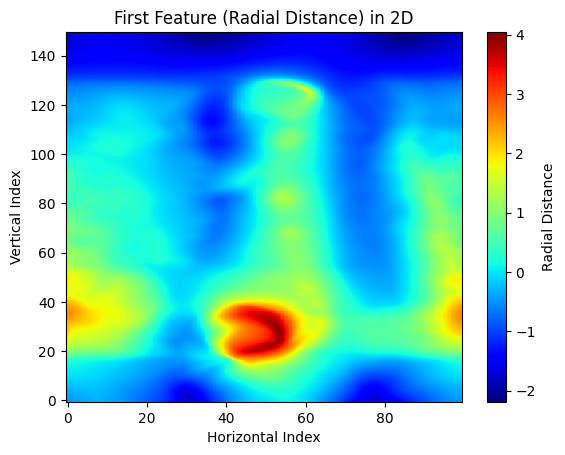

In [17]:
example_rd_tensor = train_dataset[0][0][0]  # shape: (150, 100)
# Convert to NumPy
radial_distance = example_rd_tensor.cpu().numpy() 

# Then plot as before
plt.imshow(radial_distance, origin='lower', cmap='jet', aspect='auto')
plt.colorbar(label="Radial Distance")
plt.title("First Feature (Radial Distance) in 2D")
plt.xlabel("Horizontal Index")
plt.ylabel("Vertical Index")
plt.show()

## Naive CNN model

### First we create a trainer

In [1]:
class Trainer(pl.LightningModule):
    def __init__(self, model = None):
        super(Trainer, self).__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):  
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

NameError: name 'pl' is not defined

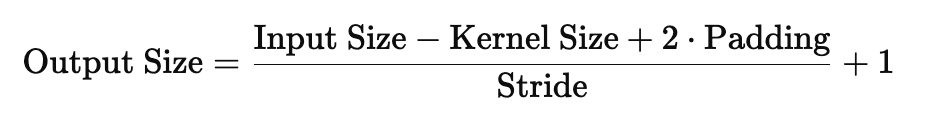

In [ ]:
def calculate_output_shape(height, width):
    """
    Helper to compute output (height, width) after convolution block
    """
    for _ in range(3):
        # Conv layer
        height = ((height + 2*1 - (3 - 1) - 1) // 1) + 1
        width  = ((width  + 2*1 - (3 - 1) - 1) // 1) + 1
        # Pool layer
        height = ((height - (2 - 1) - 1) // 2) + 1
        width  = ((width  - (2 - 1) - 1) // 2) + 1
    
    return height, width
calculate_output_shape(150, 100)

(18, 12)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        ##########################################################
        # 1) Three 2D convolutional layers
        # 2) A MaxPool2d layer self.pool
        # 3) A Dropout layer self.dropout with probability 0.5
        # 4) Two fully connected layers
        #    -> Remember to compute in_features for self.fc1 based on
        #       the output shape after the Conv+Pool layers.
        ##########################################################

        # Conv2d: in_channels=14  (since your data has shape [B, 14, 150, 100])
        #          out_channels=32/64/128
        #          kernel_size=3, stride=1, padding=1 (typical “same” conv)
        self.conv1 = nn.Conv2d(in_channels=14, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # MaxPool2d: kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Compute the spatial output size after 3 conv+pool layers
        out_h, out_w = calculate_output_shape(150, 100)

        # Fully Connected layers
        # After the last conv/pool, you have 128 channels with size out_h x out_w
        self.fc1 = nn.Linear(128 * out_h * out_w, 256)
        self.fc2 = nn.Linear(256, num_classes)

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

    def forward(self, x):
        """
        Forward pass:
        x shape = [batch_size, 14, 150, 100]
        """
        # 1) First conv + ReLU + pool
        x = F.relu(self.conv1(x))  # [B, 32, 150, 100]
        x = self.pool(x)           # [B, 32,  75,  50]

        # 2) Second conv + ReLU + pool
        x = F.relu(self.conv2(x))  # [B, 64,  75,  50]
        x = self.pool(x)           # [B, 64,  37,  25]

        # 3) Third conv + ReLU + pool
        x = F.relu(self.conv3(x))  # [B, 128, 37,  25]
        x = self.pool(x)           # [B, 128, 18,  12]

        # Flatten
        x = x.view(x.size(0), -1)  # [B, 128*18*12]
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()  

In this step, the first thing that I did was set up the first layer of the nn. To do this, we were asked to use a 2dCNN. I started with the 14 different in channels and used 32 as the amount of out channels. From here I chose a kernal size of 3x3 since the images are relatively big and also 3x3 helps with pattern recognition. Then I did this again but this time with 32 in channels and 64 out channels(in * 2 = out helps the model build structure and recognize patterns) and still a 3x3 kernal. I did the same for the third conv2d. I used max pool(2,2) to reduce the size and also help the model recognize patterns. I created the forward layer by taking 128*out_h*out_w inputs and turning them into 128 outputs. Then in layer 2, I created the last fully connected layer.

### Helper function for us to visualize the training process

In [21]:
class FinalPlotCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Append training and validation loss at the end of each epoch
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss:
            self.train_losses.append(train_loss.cpu().detach().item())
        
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss:
            self.val_losses.append(val_loss.cpu().detach().item())

    def on_train_end(self, trainer, pl_module):
        # Plot the losses at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

### Train the Naive CNN model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleCNN        | 7.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.700    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 193/193 [09:06<00:00,  0.35it/s, v_num=2]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 193/193 [08:17<00:00,  0.39it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 193/193 [08:14<00:00,  0.39it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 193/193 [07:58<00:00,  0.40it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 193/193 [08:09<00:00,  0.39it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 193/193 [08:18<00:00,  0.39it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 193/193 [07:45<00:00,  0.41it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 193/193 [08:07<00:00,  0.40it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 193/193 [09:09<00:0

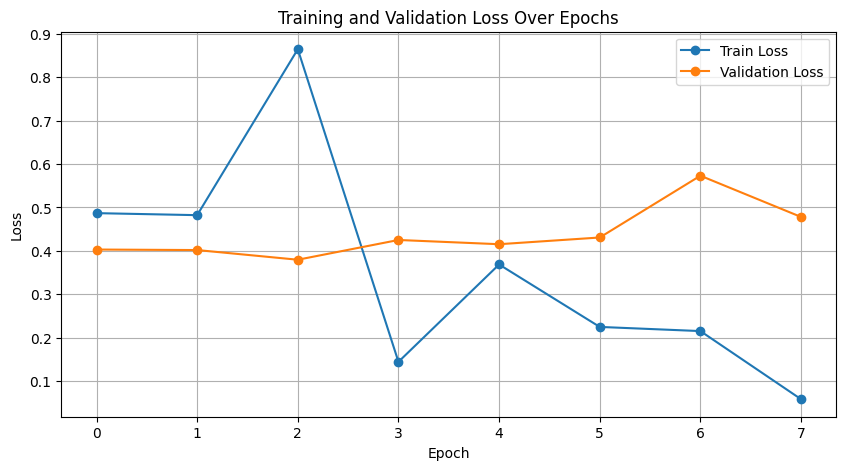

Epoch 7: 100%|██████████| 193/193 [09:10<00:00,  0.35it/s, v_num=2]


In [50]:
model = Trainer(model=SimpleCNN())
# Trainer
trainer =  pl.Trainer(max_epochs=50, callbacks=[FinalPlotCallback(), EarlyStopping(monitor='val_loss', patience=5)],)
# Training
trainer.fit(model, train_loader, val_loader)

### Testing the Naive CNN model

### Finish the testing helper function

In [1]:
def testing(model, test_loader, class_names=("CN","AD")):
    """
    Multi-class evaluation (CN/AD) with weighted metrics + macro metrics.
    Computes ROC-AUC using softmax probabilities (OVR).
    """
    model.eval()

    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for data, labels in test_loader:
            logits = model(data)

            # Fix batch_size==1 squeeze issue: [2] -> [1,2]
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)

            if logits.dim() != 2:
                raise ValueError(f"Unexpected logits shape {tuple(logits.shape)}; expected [B, C].")

            C = logits.shape[1]
            if C != 2:
                raise ValueError(
                    f"Model outputs C={C} classes, but binary testing expects 2. "
                    f"Make sure SimpleCNN(num_classes=2) and the final layer matches CN/AD."
                )

            probs = torch.softmax(logits, dim=1)      # [B,2]
            pred  = torch.argmax(probs, dim=1)        # [B]

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(pred.cpu().numpy().tolist())
            y_prob.extend(probs[:, 1].cpu().numpy().tolist())  # P(AD)

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_prob = np.asarray(y_prob)
    ##########################################################
    # TODO: Import the necessary evaluation metrics from sklearn.metrics:
    # - accuracy_score
    # - precision_score
    # - recall_score
    # - f1_score
    # - roc_auc_score
    #
    # Then, compute the following metrics using `test_label` and `test_preds`:
    # 1. Accuracy
    # 2. Precision (use 'weighted' average)
    # 3. Recall (use 'weighted' average)
    # 4. F1-Score (use 'weighted' average)
    # 5. ROC-AUC (use 'weighted' average and 'ovr' for multi_class)
    #
    # Finally, print out each metric with four decimal places in the specified format.
    ##########################################################
    # Replace "pass" statement with your code

    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, classification_report, confusion_matrix
    )
        # Core metrics
    acc = accuracy_score(y_true, y_pred)
    prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_w  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1_w   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    # Optional: macro metrics (nice to report for imbalance)
    prec_m = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_m  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_m   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # ROC-AUC (multi-class): needs probabilities, not predicted labels
    # If a class is missing in y_true for this split, roc_auc_score can error.
    roc_auc = None
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError as e:
        print(f"[WARN] ROC-AUC not computed: {e}")

    print(f"Test Accuracy:   {acc:.4f}")
    print(f"Test Precision(w): {prec_w:.4f}")
    print(f"Test Recall(w):    {rec_w:.4f}")
    print(f"Test F1(w):        {f1_w:.4f}")
    if roc_auc is not None:
        print(f"Test ROC-AUC(w, ovr): {roc_auc:.4f}")

    # Extra diagnostics - confusion matrix + full classification report
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(set(y_true)))))
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(class_names), digits=4, zero_division=0))

    # Return values as a dictionary
    return {
        "accuracy": acc,
        "precision_weighted": prec_w,
        "recall_weighted": rec_w,
        "f1_weighted": f1_w,
        "precision_macro": prec_m,
        "recall_macro": rec_m,
        "f1_macro": f1_m,
        "roc_auc_weighted_ovr": roc_auc
    }

    ##########################################################
    # END OF YOUR CODE
    ##########################################################

The model performs very well when discriminating  with an AUC-ROC of .867. This means that the hippocampal features seperate betwween Cognitive normal(CN) and AD subjects very well. Even when some cases are misclassified. This model's output gives evidence towards the fact that hippocamal degeneration is a strong way to predict if someone has Alzheimers. The structure change shows the difference between CN and AD patients. AD recall is the lowest recall(.715) showing that even though this model is good at discriminating, sometimes AD cases are missed which is a big limitation. A way to improve this is by weighting certain classes. This would help by taking some of the weight off the classes that do not help as much. You would need knowledge in the field to figure this out. 
 

In [ ]:
!zip -r bios_740.zip "Bios 740"

In [2]:
ckpt_path = "lightning_logs/version_2/checkpoints/epoch=7-step=1544.ckpt"

# loading the checkpoint
model = Trainer.load_from_checkpoint(
    ckpt_path,
    model=SimpleCNN(num_classes=2)  # important: 2 classes (CN/AD)
)
model.eval()

NameError: name 'Trainer' is not defined

In [ ]:
testing(model, test_loader)


NameError: name 'testing' is not defined

In [ ]:
# creating the csv file needed for submission.
def make_prediction_csv(model, test_df, test_loader, out_csv="predictions.csv"):
    model.eval()

    preds = []

    with torch.no_grad():
        for data, _labels in test_loader:
            logits = model(data)

            # handle batch size = 1
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)
            # logits is good
            pred = torch.argmax(logits, dim=1)  
            preds.extend(pred.cpu().numpy().tolist())  # 0=CN, 1=AD

    # Making the 2 columns needed
    sub = test_df[["PTID"]].copy()
    sub = sub.rename(columns={"PTID": "SubjectID"})
    sub["PredictedLabel"] = preds  # already 0/1

    sub.to_csv(out_csv, index=False)
    print(f"[OK] wrote {out_csv} with columns {list(sub.columns)} and {len(sub)} rows")
    return sub

pred_df = make_prediction_csv(model, test_df, test_loader, out_csv="predictions.csv")
pred_df.head()

[OK] wrote predictions.csv with columns ['SubjectID', 'PredictedLabel'] and 353 rows


,SubjectID,PredictedLabel
0,002_S_1018,0
1,002_S_1018,0
2,002_S_1018,0
3,002_S_1018,0
4,003_S_1057,1


# Try some of the models

We can try some of the modern CNN architectures like ResNet, DenseNet, etc.

In [ ]:
VGG16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)


old_conv = VGG16.features[0]  # Conv2d block
new_conv = nn.Conv2d(in_channels=14, 
                    out_channels=old_conv.out_channels,
                    kernel_size=old_conv.kernel_size,
                    stride=old_conv.stride,
                    padding=old_conv.padding,
                    bias=(old_conv.bias is not None))

VGG16.features[0] = new_conv


in_features_fc = VGG16.classifier[6].in_features
VGG16.classifier[6] = nn.Linear(in_features_fc, 2)  # 2 classes: CN, AD
print(VGG16)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /nas/longleaf/home/dawaitt/.cache/torch/hub/v0.10.0.zip
/nas/longleaf/home/dawaitt/venvs/bios740/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nas/longleaf/home/dawaitt/venvs/bios740/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
x = torch.randn(1, 14, 224, 224)  # Batch size 1, 5 channels, 224x224
VGG16(x)

tensor([[ 0.1936, -0.0842]], grad_fn=<AddmmBackward0>)

In [ ]:
model = Trainer(model=VGG16)
# Trainer
trainer =  pl.Trainer(max_epochs=50, callbacks=[FinalPlotCallback(), EarlyStopping(monitor='val_loss', patience=5)])
# Training
trainer.fit(model, train_loader, val_loader)

NameError: name 'Trainer' is not defined

In [ ]:
import glob
print(glob.glob("lightning_logs/**/checkpoints/*.ckpt", recursive=True)[:10])

['lightning_logs/version_2/checkpoints/epoch=7-step=1544.ckpt']


In [ ]:
def make_prediction_csv(model, test_df, out_path="test_predictions.csv"):
    """
    Creates CSV with columns: SubjectID, PredictedLabel
    PredictedLabel: 0 = CN (healthy), 1 = AD
    """
    model.eval()

    # IMPORTANT: build a dataset from test_df in the same order as test_df
    test_dataset_ordered = HippocampusDataset(test_df)

    preds = []
    with torch.no_grad():
        for i in range(len(test_dataset_ordered)):
            x, _ = test_dataset_ordered[i]        # x: [14,150,100]
            x = x.unsqueeze(0)                    # -> [1,14,150,100]
            logits = model(x)

            # If logits becomes shape [2] for batch size 1, fix it
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)      # [1,2]

            pred = torch.argmax(logits, dim=1).item()  # 0 or 1
            preds.append(pred)

    out = pd.DataFrame({
        "SubjectID": test_df["PTID"].values,
        "PredictedLabel": np.array(preds, dtype=int)
    })

    out.to_csv(out_path, index=False)
    print(f"Saved {len(out)} predictions to: {out_path}")
    print(out.head())

# Run it:
make_prediction_csv(model, test_df, out_path="test_predictions.csv")

NameError: name 'model' is not defined